# The mathematics of fitting logistic regression

## Explaining the Model

In this notebook we explain the mathematics behind fitting simple logistic regression.

In [6]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

We will explain using a toy example.  A standard apple tree which is only $1$ foot tall is unlikely to bear fruit this year.  However an apple tree which is $20$ feet tall is very likely to be of bearing age.  We might expect an increasing relationship between the height of the tree and the probability that the tree is capable of bearing fruit.



In [7]:
height_vs_bearing = pd.read_csv('math_hour_7_assets/height_vs_bearing.csv', index_col=0)

In [8]:
height_vs_bearing

,height,bearing
0,11.325206,0.0
1,12.939280,1.0
2,9.767215,1.0
3,7.638947,0.0
4,8.997293,0.0
...,...,...
95,12.316341,1.0
96,8.523462,0.0
97,7.432771,0.0
98,7.105060,0.0


We can see that we have measured the height of 100 apple trees, and recorded whether or not the tree is currently bearing apples.

Here is a graph of the data:

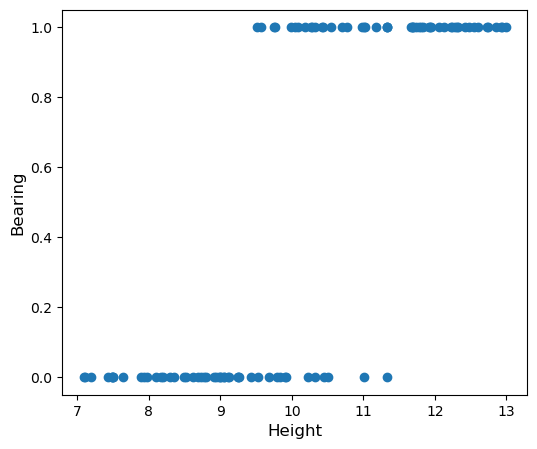

In [9]:
X = height_vs_bearing['height']
y = height_vs_bearing['bearing']
plt.figure(figsize=(6,5))

plt.scatter(X, y)

plt.xlabel("Height", fontsize=12)
plt.ylabel("Bearing", fontsize=12)
plt.show()

As we can see, when the tree is shorter than 9 feet tall it is very rare for it to bear apples.  When it is taller than 11.5 feet tall it is almost surely going to bear apples.  In between we have a murkier situation.  One thing we could do to try to get a better understanding of this relationship is try and see how the probability of bearing varies as a function of height.  We can estimate the probability $P(\textrm{bearing} = 1 | x )$ by looking at the empirical probability of bearing in a small neighborhood of $x$, say $$P(\textrm{bearing} = 1 | \textrm{height} = x ) \approx \frac{\textrm{\# samples bearing}}{\textrm{\# samples in }[x-0.5,x+0.5]}$$  

Let's take a look at that graph.  I have highlighted the point with $\textrm{height} = 9.5$ green.  In the interval $[9,10]$ there are $20$ samples of which $5$ are bearing, for an estimated probability of $\frac{5}{20} = 0.25$

![Approximate probabilities](math_hour_7_assets/approx-probs.png)

We would like to model the probability as a funtion of height directly.  Our model might look something like this:

![approximate probabilities with logistic regression curve](math_hour_7_assets/approx-probs-with-curve.png)

In logistic regression we will model the probability $P(\textrm{bearing} = 1| \textrm{height} = x)$ using a function of the form $p(x) = \sigma(mx+b)$ where $\sigma$ is the *sigmoid function* defined by

$$
\sigma(t) = \frac{1}{1+e^{-t}}
$$

We can interpret this as follows

$$
\begin{align*}
&p(x) = \frac{1}{1+e^{-(mx+b)}}\\
&\frac{1}{p(x)} = 1 + e^{-(mx+b)}\\
&\frac{1 - p(x)}{p(x)} = e^{-(mx+b)}\\
&\frac{p(x)}{1-p(x)} = e^{mx+b}\\
&\log\left(\frac{p(x)}{1-p(x)}\right) = mx+b
\end{align*}
$$

The quantity $\frac{p(x)}{1-p(x)}$ is the [odds](https://en.wikipedia.org/wiki/Odds) in favor of bearing.

So by modeling our probability using the parameteric family $p(x) = \sigma(mx+b)$ we are making the assumption that the log-odds in favor of bearing is approximately linear in the height.  In other words, we are assuming that each foot of height increases the log-odds in favor of bearing by a fixed amount ($m$).  This assumption may or may not be reasonable, just like fitting a linear regression may or may not be reasonable.  In this case our exploratory plot makes it look like a reasonable model.

## The Binary Cross Entropy Loss Function

We will increase the generality a bit and think about an appropriate loss function for **any** conditional probability with binary outcomes.

We have $N$ samples which each have $k$ continuous variables $x_1, x_2, x_3, ..., x_k$ and one binary variable $y$ (which is either $0$ or $1$ for each sample).  We want to model the probability that $y = 1$ as a function of these variables using a model with parameters $\theta = (\theta_1, \theta_2, \theta_3, ..., \theta_m)$ where $\theta \in \Theta \subset \mathbb{R}^m$.  In other words, we want to model the probability as some function $p_\theta: \mathbb{R}^k \to [0,1]$ which depends on these parameters.  

For example, in the situation with age and income predicting voting in an upcoming election, we might model the probability of voting as 

$$
p_\theta (\vec{x}) = \frac{1}{1 + e^{ - (\theta_0 + \theta_1 x_1 + \theta_2 x_2)}}
$$

where $x_1$ is age and $x_2$ is income.  This is only an example though:  depending on the data there might be other parametric families of functions we might want to select as our model.  The particular example we used here is an example of multiple logistic regression.

The question we have is how to select the parameters $\theta$ so as to maximize the likelyhood that the data in our sample was generated by the model. 

Fix the parameters $\theta$.  For a single observation $(\vec{x},y)$ the model predicts this observation will occur with a probability of

$$
\begin{cases}
p_\theta(\vec{x}) \textrm{ if $y = 1$}\\
1 - p_\theta(\vec{x}) \textrm{ if $y = 0$}
\end{cases}
$$

We can write this more compactly as the single expression 

$$
y p_\theta(\vec{x}) + (1-y)(1 - p_\theta(\vec{x}))
$$

So our model predicts that the probability that our sample of $N$ observations occurs is 

$$
L(\theta) = \prod_{i=1}^{N} \left(y_i p_\theta(\vec{x_i}) + (1-y_i)(1 - p_\theta(\vec{x_i}))\right)
$$

Our goal is to find the value of $\theta$ which maximizes this quantity.

We are now going to take the logarithm of the likelyhood function:

$$
\log(L(\theta)) = \sum_{i = 1}^{N} y_i \log (p_\theta(\vec{x_1}))  + (1 - y_i)\log(1 - p_\theta(\vec{x_i}))
$$

Why did we take the logarithm?  Several reasons:

* The logarithm is monotonically increasing, so the same $\theta$ maximizes both $L$ and $\log L$.
* The values of $L$ are probably quite small.  We are multiplying together lots of numbers which are between $0$ and $1$.  The result will be a tiny positive number.  Using a logarithmic transformation is a nice way to put these numbers on a more reasonable scale.
* We will eventually want to differentiate to find a maximum value.  The derivative of the likelyhood uses the product rule, which would involve a product over all observations.  This is not very parallelizable.  The derivative of the log-likelyhood only uses the sum rule, which results in a parallelizable derivative computation.

The log-likelyhood is a negative number which we are trying to maximize.  By convention we will instead minimize the negative log-likelyhood:

$$
 \ell(\theta) = - \log(L(\theta)) = - \sum_{i = 1}^{N} y_i \log (p_\theta(\vec{x_1}))  + (1 - y_i)\log(1 - p_\theta(\vec{x_i}))
$$

where I am using $\ell$ to stand for "loss".

This expression is called the [binary cross-entropy](https://en.wikipedia.org/wiki/Cross_entropy) between the model $p_\theta$ and the empirical probability from our observations $(\vec{x_i}, y_i)$.

## Fitting the Model

Returning to simple logistic regression, 

$$
\ell(m,b) = -\sum_{i = 1}^N y_i\log(p_{m,b}(x_i)) + (1- y_i)\log(1- p_{m,b}(x_i))
$$

We are going to find the gradient of this loss function.  Before that, it is convenient to note a few special properties of the sigmoid function:


1. &nbsp;  $1- \sigma(z) = \sigma(-z)$
2. &nbsp;  $\frac{\sigma(z)}{\sigma(-z)} = e^z$
3.  &nbsp; $\frac{\textrm{d}}{\textrm{d}z} \sigma(z) = \sigma(z) \sigma( - z)$


These properties are all elementary to derive, so we skip the derivations.

We first use these properties to rewrite the loss function in a more convenient form:

$$
\begin{align*}
\ell(m,b) 
&= -\sum_{i = 1}^N y_i\log(p_{m,b}(x_i)) + (1- y_i)\log(1- p_{m,b}(x_i))\\
& = -\sum_{i=1}^n y_i \log(\sigma(mx_i+b)) + (1- y_i)\log(1- \sigma(mx_i + b))\\
& = -\sum_{i=1}^n y_i \log(\sigma(mx_i+b)) + (1- y_i)\log(\sigma(-(mx_i + b))) \textrm{ by 1.}\\
& = -\sum_{i=1}^n y_i \log(\frac{\sigma(mx_i + b)}{\sigma(-mx_i + b)}) + \log(\sigma(-(mx_i + b)))\\
& = -\sum_{i=1}^n y_i \log(e^{mx_i+b}) + \log(\sigma(-(mx_i + b))) \textrm{ by 2.}\\
& = -\sum_{i=1}^n y_i(mx_i + b) + \log(\sigma(-(mx_i + b))) \textrm{ by 2.}\\

\end{align*}
$$

We are now in a strong position to take partial derivatives:

$$
\begin{align*}
\frac{\partial \ell}{\partial b} 
&= -\sum_{i=1}^n   y_i - \frac{1}{\sigma(-(mx_i + b))} \sigma(-(mx_i + b))\sigma( mx_i + b) \textrm{ by 3.}\\
&= \sum_{i=1}^n \sigma( mx_i + b)  -  y_i \\
& = \sum_{i=1}^n p_{m,b}(x_i)  -  y_i \\
\end{align*}
$$

$$
\begin{align*}
\frac{\partial \ell}{\partial m}
&= -\sum_{i=1}^n y_ix_i  + -x_i \frac{1}{\sigma(-(mx_i + b))} \sigma(-(mx_i + b))\sigma( mx_i + b)\\
& = \sum_{i=1}^n x_i (p_{m,b}(x_i) - y_i) \\ 
\end{align*}
$$

It is amazing to me that these partial derivatives up having such (relatively) simple expressions!

If we package things a little differently the formula becomes even more compact.

Let 

$$
X = \begin{bmatrix} \vec{1} & \vec{x}\end{bmatrix} \hphantom{dsds} \vec{\beta} = \begin{bmatrix} b \\ m\end{bmatrix}
$$

Then it is easy to check that 

$$
\nabla \ell =  X^\top (p_{\vec{\beta}}(\vec{x}) - \vec{y})
$$


To minimize the loss function we need to find where the gradient vanishes.  Unfortunately, we cannot solve this analytically.  We will instead resort to numerical approximation.  We will use gradient descent.

In [10]:
import math

# This is a function for fitting simple linear regression using batch gradient descent.
# X, y, m_start, and b_start are hopefully self-explanatory.  
# lr stands for "learning rate" and is the amount we will scale the gradient at each step.
# we continue to run gradient descent until the length of the gradient is less than the tolerance.

def fit_logistic_regression(X, y, m_start, b_start, lr, tolerance):
    m = m_start
    b = b_start
    probs = 1/(1+np.exp(-(m*X+b))) #applying sigma to mX+b to get the vector of predicted probabilities.
    loss = -(np.dot(y, np.log(probs)) + np.dot(1-y, np.log(1- probs))) # This is the formula for log-loss
    partial_b = (probs - y).sum() #formula for partial derivative of the loss with respect to b
    partial_m = (X*(probs - y)).sum() #formula for partial derivative of the loss with respect to m

    i = 0 # a counter for the number of iterations

    #we adjust m and b by h times the gradient while the length of the gradient is greater than our tolerance.
    while  partial_b**2+  partial_m**2> tolerance**2:
        b -= lr*partial_b
        m -= lr*partial_m
        probs = 1/(1+np.exp(-(m*X+b)))
        loss = -(np.dot(y, np.log(probs)) + np.dot(1-y, np.log(1 - probs)))
        partial_b = (probs - y).sum()
        partial_m = (X*(probs - y)).sum()
        i += 1
        if i%10000 == 0:
            print('i = ',i, ', m = ' ,m, ',b = ', b, ', length of grad = ', (partial_b**2 + partial_m**2)**0.5,', loss = ', loss)
    return np.array([m,b]) 


#My initial guess of m = 2, b = -20 is an educated guess.  Looking at the rough sketch we made of the probability curve when we first started, it looks like 
#we have an inflection point at around (10,0.5) with a slope of 2.  This gives m = 2 and b = -20 after a little fiddling.  I could have started with a random
#guess, and it would have just taken a little longer to converge.

#Note this is a *very* inefficient implementation, just to get the ideas across, and takes my computer 5 minutes to run.
optimal_params = fit_logistic_regression(X, y, 2,-20, 0.001, 0.001)  
print(optimal_params)

i =  10000 , m =  2.1192925120808486 ,b =  -21.363434233036898 , length of grad =  0.10228932435579309 , loss =  25.767335341763896
i =  20000 , m =  2.1982278706290144 ,b =  -22.160779730581684 , length of grad =  0.06196204684618228 , loss =  25.701795112354908
i =  30000 , m =  2.2469638105490164 ,b =  -22.65293633322963 , length of grad =  0.03894879542488671 , loss =  25.676897814266447
i =  40000 , m =  2.2779373951277435 ,b =  -22.965671504577948 , length of grad =  0.0250140359073281 , loss =  25.666860746257555
i =  50000 , m =  2.297963048823149 ,b =  -23.16784798506587 , length of grad =  0.01627675493892682 , loss =  25.662669841937785
i =  60000 , m =  2.3110487729434905 ,b =  -23.299951973407392 , length of grad =  0.010679251103460782 , loss =  25.660881592611187
i =  70000 , m =  2.3196575838564413 ,b =  -23.386857002330622 , length of grad =  0.007044015039684102 , loss =  25.66010797255713
i =  80000 , m =  2.325345914808644 ,b =  -23.444278690927113 , length of grad 

In contrast to our gradient descent function, scikit-learn fits the model almost instantly!  They are using some much more sophisticated numerical analysis.  See [the Broyden–Fletcher–Goldfarb–Shanno algorithm](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm) for more details.

In [11]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(penalty=None)

## fit the model
log_reg.fit(X.to_numpy().reshape(-1,1),y.to_numpy())

print(f'Our gradient descent function obtains the fit m = {optimal_params[0]} and b = {optimal_params[1]}')
print(f'sklearn obtains the fit m = {log_reg.coef_[0][0]} and b = { log_reg.intercept_[0]}')
print('These are pretty close!')

Our gradient descent function obtains the fit m = 2.334168205898299 and b = -23.533334418191455
sklearn obtains the fit m = 2.3365872747509924 and b = -23.557743891760303
These are pretty close!


Let's see how the fit generated by sklearn looks.  You can check that the fit we obtained using gradient descent is indistinguishable to the human eye by uncommenting a line in the code below:

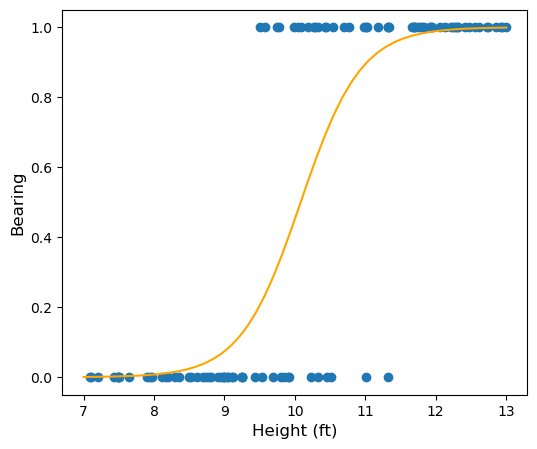

In [12]:
plt.figure(figsize=(6,5))

plt.scatter(X.to_numpy(), y.to_numpy())

sigmoid = lambda t: 1/(1+math.exp(-t))
plt.plot(np.linspace(7,13), np.vectorize(lambda x: sigmoid(log_reg.intercept_[0] + log_reg.coef_[0][0]*x))(np.linspace(7,13)), color = 'orange')
#plt.plot(np.linspace(7,13), np.vectorize(lambda x: sigmoid(optimal_params[1] + optimal_params[0]*x))(np.linspace(7,13)), color = 'red')

plt.xlabel("Height (ft)", fontsize=12)
plt.ylabel("Bearing", fontsize=12)
plt.show()

# Uniqueness of Fit

When gradient descent converges it converges to a *local* minimum.  It is possible that our loss function could have more than one local min.  It turns out that when we are fitting logistic regression using cross-entropy loss the loss function is **convex** which ensures uniqueness of the global minimum (if it exists).  We can show this by computing the Hessian matrix of the loss function and checking that it is positive definite.  The Hessian matrix is

$$
\begin{bmatrix}
\frac{\partial^2 \ell}{\partial b^2} & \frac{\partial^2 \ell}{\partial b \partial m}\\
\frac{\partial^2 \ell}{\partial b \partial m} & \frac{\partial^2 \ell}{\partial m^2}
\end{bmatrix}
$$

Let's compute these partials:

$$
\begin{align*}
\frac{\partial^2 \ell}{\partial b^2} 
&= \frac{\partial}{\partial b} \sum_{i=1}^n p_{m,b}(x_i)  -  y_i\\
&= \frac{\partial}{\partial b} \sum_{i=1}^n \sigma(mx_i + b)  -  y_i\\
&=  \sum_{i=1}^n \sigma(mx_i + b)\sigma( -(mx_i + b))\\
&\\
\frac{\partial^2 \ell}{\partial b \partial m}
&= \frac{\partial}{\partial b} \sum_{i=1}^n x_i (p_{m,b}(x_i) - y_i)\\
&= \frac{\partial}{\partial b} \sum_{i=1}^n x_i( \sigma(mx_i + b)  -  y_i) \\
&= \sum_{i=1}^n x_i \sigma(mx_i + b)\sigma( -(mx_i + b))
&\\
\frac{\partial^2 \ell}{\partial m^2}
&= \frac{\partial}{\partial m} \sum_{i=1}^n x_i (p_{m,b}(x_i) - y_i)\\
&= \frac{\partial}{\partial m} \sum_{i=1}^n x_i( \sigma(mx_i + b)  -  y_i) \\
&= \sum_{i=1}^n x_i^2 \sigma(mx_i + b)\sigma( -(mx_i + b)) 
\end{align*}
$$

This Hessian matrix can be written more compactly as 

$$
H = X^\top D X
$$

where $D$ is the diagonal matrix with entires $D_{ii} = \sigma(mx_i + b)\sigma( -(mx_i + b)) > 0$.

This allows us to easily see that the Hessian is positive semi-definite:

$$
\begin{align*}
\vec{v}^\top H \vec{v} 
&= \vec{v}^\top X^\top D X \vec{v}\\
&= (X \vec{v})^\top D (X \vec{v})\\
&\geq \textrm{min}_i(D_{ii}) |X \vec{v}|^2 \\
&\geq 0
\end{align*}
$$

Hence $\ell$ is convex and has a unique global minimum (assuming that the global minimum exists). 

It is possible that there is no global minimum!  This happens when we have perfect seperation of our classes.  For instance, imagine that all trees with height less than $10$ feet were not bearing, and all trees with height greater than $10$ feet were bearing.

$$
p_{m,b} = \sigma(mx + b)
$$

Let's find which values of the parameters make $p_{m,b}(10) = \frac{1}{2}$:

$$
\begin{align*}
&\sigma(10m + b) = \frac{1}{2}\\
&\frac{1}{1+e^{-(10m+b)}} = \frac{1}{2}\\
&e^{-(10m+b)} = 1\\
&10m+b = 0\\
&b = -10m
\end{align*}
$$

Let's plot some of these against some fake data:

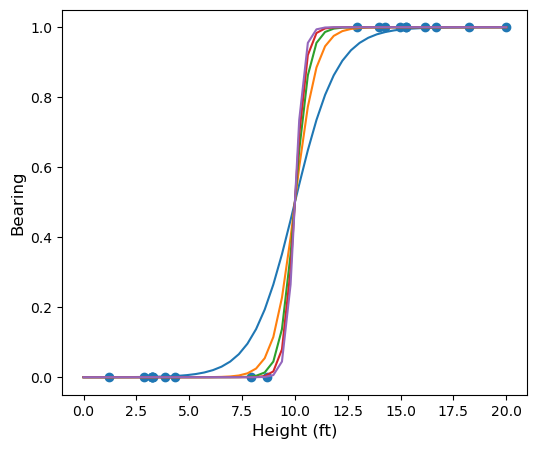

In [13]:
plt.figure(figsize=(6,5))

X = np.concatenate([np.random.uniform(0,9,10), np.random.uniform(11,20,10)] )
y = np.concatenate([np.zeros(10),np.ones(10)])

plt.scatter(X, y )

sigmoid = lambda t: 1/(1+math.exp(-t))
for m in range(1,6):  
    plt.plot(np.linspace(0,20), np.vectorize(lambda x: sigmoid(m*x + -10*m))(np.linspace(0,20)))

plt.xlabel("Height (ft)", fontsize=12)
plt.ylabel("Bearing", fontsize=12)
plt.show()

As you can see, if we allow $m \to \infty$ along the line $10m + b = 0$, the fit of logistic regression becomes better and better.  In the limit the logistic loss function approaches $0$.

## Fitting Multiple Logistic Regression

Set up:

We have $k$ features $x_1, x_2, ..., x_k$ and a binary response variable $y$.  We have a sample of $N$ observations.  The $i^{th}$ observation has $x_1 = x_{i1}, x_2 = x_{i2}, ... , x_k = x_{ik}$.

Let 

$$\vec{x} = \begin{bmatrix} 1 & x_1 & ... & x_k \end{bmatrix}^\top$$

$$\vec{\beta} = \begin{bmatrix} \beta_0 & \beta_1 & ... & \beta_k \end{bmatrix}^\top$$

and

$$
\vec{y} = \begin{bmatrix} y_1 & y_2 & y_3 ... & y_n\end{bmatrix}^\top
$$

We are modeling the probability that $y = 1$ given the values $\vec{x}$ for our features as

$$
p_{\vec{\beta}}(\vec{x}) = \sigma(\vec{\beta} \cdot \vec{x})
$$

Introducing a bit more notation, let $X$ be the $N$ by $k+1$ matrix

$$
X = \begin{bmatrix}
1 & x_{11} & x_{12} & ... & x_{1k}\\
  &        & \vdots &     &       \\
1 & x_{N1} & x_{N2} & ... & x_{Nk}\\
\end{bmatrix}
$$

In the following formula when we apply $\log$ or $\sigma$ to a vector or matrix,  understand this as applying the function to each coordinate.  

I perform the calculation of the gradient and hessian using the calculus described in the papers here:  [https://www.matrixcalculus.org/about](https://www.matrixcalculus.org/about).  Be sure to check out their calculator as well!

$\vec{1}$ stands for a vector of ones of the appropriate dimension.  $\textrm{diag}(\vec{v})$ is the square matrix whose diagonal is the vector $v$ and $\textrm{diag}(A)$ is the diagonal vector of the matrix $A$.  $\odot$ is element-wise multiplication, $\oslash$ is element-wise division.

We will fit this model by minimizing the binary cross-entropy.  

$$
\begin{align*}
\ell(\vec{\beta}) &= - \left( \vec{y} \cdot \log(\sigma(X \vec{\beta}))  + ( \vec{1} - \vec{y}) \cdot \log(1- \sigma(X \vec{\beta}))\right)\\
&=- \left( \vec{y} \cdot \log(\sigma(X \vec{\beta}))  + ( \vec{1} - \vec{y}) \cdot \log(\sigma( -X \vec{\beta}))\right) \textrm{ since $1-\sigma(t) = \sigma(-t)$}\\
&= -\vec{y} \cdot \log(\sigma(X \vec{\beta}))  + ( \vec{y} - \vec{1}) \cdot \log(\sigma( -X \vec{\beta}))
\end{align*}
$$

We compute $\nabla \ell$ as follows:

$$
\begin{align*}
\nabla \ell(\vec{\beta}) 
&= - X^\top \left( \vec{y} \oslash \sigma(X \vec{\beta}) \right) \odot \sigma(X \vec{\beta}) \odot \sigma(-X \vec{\beta}) - X^\top \left( ((\vec{y} - \vec{1}) \oslash \sigma(-X \vec{\beta})) \odot \sigma(-X\vec{\beta}) \odot \sigma(X \vec{\beta})\right)\\
&= -X^\top \left( \vec{y} \odot \sigma(X \vec{\beta}) + (\vec{y} - \vec{1}) \odot \sigma(X \vec{\beta}) \right)\\
&= -X^\top \left( \vec{y} \odot (\sigma(X \vec{\beta}) + \sigma(-X \vec{\beta})) - \sigma(X\vec{\beta})\right)\\
&= X^\top \left( \sigma(X\vec{\beta}) - \vec{y} \right) \textrm{ since $\sigma(t) + \sigma(-t) = 1$}\\
&= X^\top \left( p_{\vec{\beta}}(X) - \vec{y}\right)
\end{align*}
$$

As a sanity check, note that this recovers the formula for the gradient of the loss function we obtained in simple logistic regression!




We now compute the Hessian:

$$
\begin{align*}
H 
&= \frac{\partial}{\partial \vec{\beta}} \left( X^\top \left( p_{\vec{\beta}}(X) - \vec{y}\right) \right)\\
&= \frac{\partial}{\partial \vec{\beta}} \left( X^\top \left( \sigma(X \vec{\beta}) - \vec{y}\right) \right)\\
&= X^\top D X
\end{align*}
$$

where $D$ is the diagonal matrix with entries $\sigma'(X \vec{\beta}) = \sigma(X \vec{\beta}) \sigma(-X\vec{\beta})$.

This is clearly positive semidefinite, and so multiple logistic regression is also a convex optimization problem.